<a href="https://colab.research.google.com/github/FahmidaNourin/GNN/blob/main/gnn_first_try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
DATA_PATH = "/content/drive/MyDrive/nourin_R/data/raw/HIV_train.csv"
data = pd.read_csv(DATA_PATH)
data.head()

,index,smiles,activity,HIV_active
0,3999,CC1c2nc(N)nc(N)c2CN1C(=O)c1ccccc1,CI,0
1,4000,Cc1nc(N)c2c(n1)C(C)N(C(=O)c1ccccc1)C2,CI,0
2,4001,NC(=S)NN=Cc1ccc(O)cn1,CI,0
3,4002,COC1C(OC(=O)c2ccc(C)[nH]2)C(O)C(Oc2ccc3c(O)c(N...,CM,1
4,4003,O=C1C=C2C=CC3CC2(O1)C1CCCCN31,CI,0


# General information about the dataset

In [3]:
print(data.shape)
print(data["HIV_active"].value_counts())

(37128, 4)
HIV_active
0    35850
1     1278
Name: count, dtype: int64


# Show sample molecules

In [4]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 32.7 MB/s eta 0:00:00


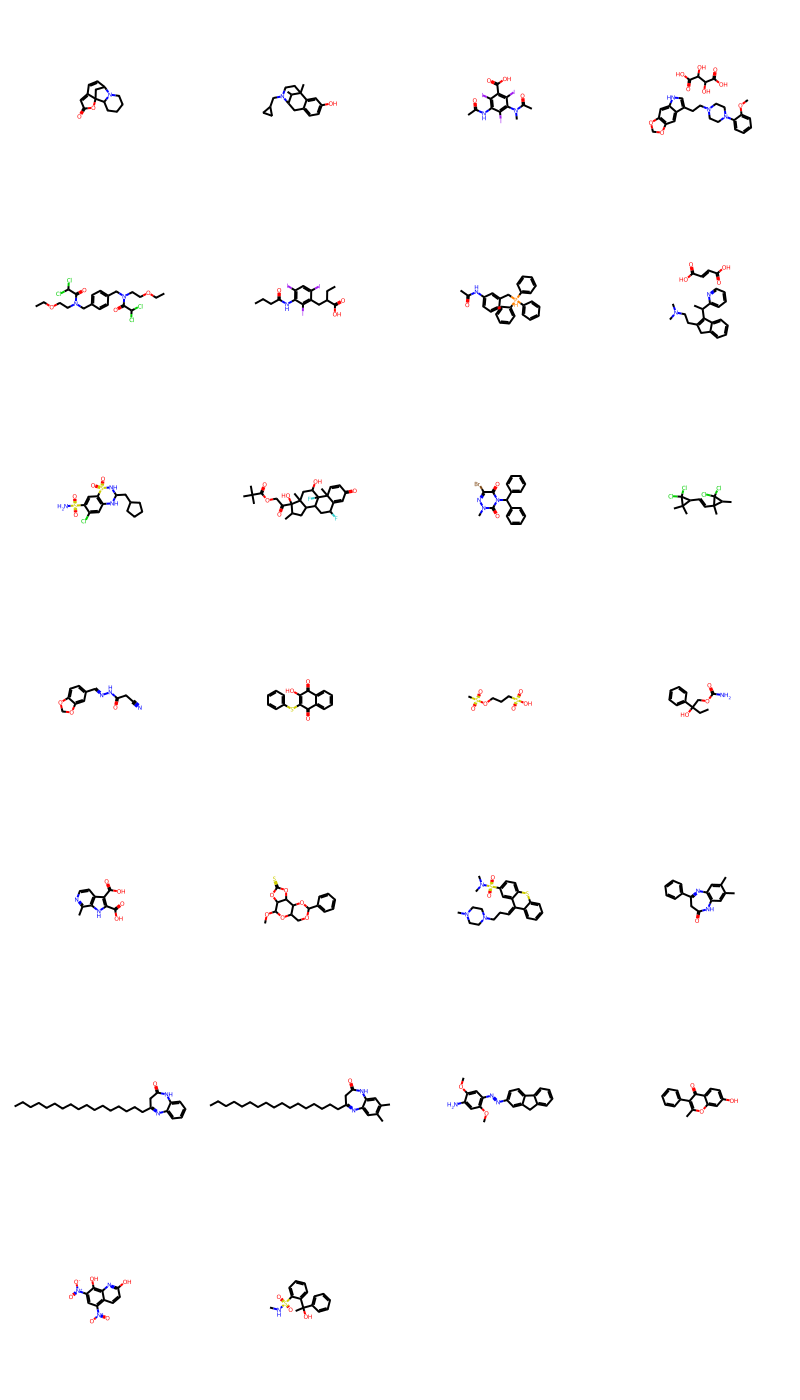

In [5]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw

sample_smiles = data["smiles"][4:30].values
sample_mols = [Chem.MolFromSmiles(smiles) for \
               smiles in sample_smiles]
grid = Draw.MolsToGridImage(sample_mols,molsPerRow=4,subImgSize=(200,200))

grid


# Quick check with versions

In [6]:
import torch

print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.3.0+cu121


In [7]:
import torch

cuda_available = torch.cuda.is_available()
cuda_version = torch.version.cuda

print(f"CUDA available: {cuda_available}")
print(f"CUDA version: {cuda_version}")

CUDA available: False
CUDA version: 12.1


In [8]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.1 MB/s eta 0:00:00


In [9]:
import torch
import torch_geometric

print(f"Torch version: {torch.__version__}")
print(f"Cuda available: {torch.cuda.is_available()}")
print(f"Torch geometric version: {torch_geometric.__version__}")

Torch version: 2.3.0+cu121
Cuda available: False
Torch geometric version: 2.5.3


# Generate a dataset

In [10]:
from torch_geometric.data import Dataset, Data
import numpy as np
import os
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdmolops
from tqdm import tqdm
import torch

class MoleculeDataset(Dataset):
    def __init__(self, root, transform=None, pre_transform=None):
        """
        root = Where the dataset should be stored. This folder is split
        into raw_dir (download dataset) and processed_dir(processed data)
        """
        super(MoleculeDataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        """
        If this file exists in raw_dir, the download is not triggered.
        (the download function is not implemented here)
        """
        return 'HIV.csv'

    @property
    def processed_file_names(self):
        """
        If these files are found in processed_dir, processing is skipped.
        """
        return 'not_implemented.pt'

    def download(self):
        pass

    def process(self):
        self.data = pd.read_csv(self.raw_paths[0])
        for index, mol in tqdm(self.data.iterrows(), total=self.data.shape[0]):
            mol_obj = Chem.MolFromSmiles(mol["smiles"])
            # Get node features
            node_feats = self._get_node_features(mol_obj)
            # Get edge features
            edge_feats = self._get_edge_features(mol_obj)
            # Get adjacency info
            edge_index = self._get_adjacency_info(mol_obj)
            label = self._get_labels(mol["HIV_active"])

            # Create data object
            data = Data(x=node_feats,
                        edge_index=edge_index,
                        edge_attr=edge_feats,
                        y=label,
                        smiles=mol["smiles"]
                        )
            torch.save(data,
                       os.path.join(self.processed_dir,
                                    f'data_{index}.pt'))

    def _get_node_features(self, mol):
        """
        This will return a matrix / 2d array of the shape
        [Number of Nodes, Node Feature size]
        """
        all_node_feats = []
        for atom in mol.GetAtoms():
            node_feats = []
            # Feature 1: Atomic number
            node_feats.append(atom.GetAtomicNum())
            # Feature 2: Atom degree
            node_feats.append(atom.GetDegree())
            # Feature 3: Formal charge
            node_feats.append(atom.GetFormalCharge())
            # Feature 4: Hybridization
            node_feats.append(int(atom.GetHybridization()))
            # Feature 5: Aromaticity
            node_feats.append(int(atom.GetIsAromatic()))
            # Append node features to matrix
            all_node_feats.append(node_feats)

        all_node_feats = np.asarray(all_node_feats)
        return torch.tensor(all_node_feats, dtype=torch.float)

    def _get_edge_features(self, mol):
        """
        This will return a matrix / 2d array of the shape
        [Number of edges, Edge Feature size]
        """
        all_edge_feats = []

        for bond in mol.GetBonds():
            edge_feats = []
            # Feature 1: Bond type (as double)
            edge_feats.append(bond.GetBondTypeAsDouble())
            # Feature 2: Rings
            edge_feats.append(bond.IsInRing())
            # Append edge features to matrix
            all_edge_feats.append(edge_feats)

        all_edge_feats = np.asarray(all_edge_feats)
        return torch.tensor(all_edge_feats, dtype=torch.float)

    def _get_adjacency_info(self, mol):
        adj_matrix = rdmolops.GetAdjacencyMatrix(mol)
        row, col = np.where(adj_matrix)
        coo = np.array([row, col])
        return torch.tensor(coo, dtype=torch.long)

    def _get_labels(self, label):
        label = np.asarray([label])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
        return self.data.shape[0]

    def get(self, idx):
        """Equivalent to __getitem__ in PyTorch.
           Is not needed for PyG's InMemoryDataset.
        """
        data = torch.load(os.path.join(self.processed_dir,
                                       f'data_{idx}.pt'))
        return data


In [ ]:
dataset = MoleculeDataset(root="/content/drive/MyDrive/nourin_R/data/")
print(dataset[0].edge_index.t())
print(dataset[0].x)
print(dataset[0].edge_attr)
print(dataset[0].y)

Processing...
 66%|██████▌   | 24421/37128 [05:06<02:45, 76.93it/s]

# Test the dataset